# **EM (Expectation-Minimization) CLUSTERING ANALYSIS**

In [63]:
# Import Libraries
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

## Question 1
Functions and Comments

In [ ]:
# Define the main EM clustering function
def exp_max(Iter, K, pdf, train, Xmat, W_Init, P_Init):
    """
    Implements the Expectation-Maximization (EM) algorithm for clustering.

    Args:
        Iter (int): The number of iterations for which the algorithm should run.
        K (int): The number of clusters.
        pdf (function): A probability density function (e.g., normal_pdf) that takes parameters
                        (e.g., mean) and data (Xmat) to return probabilities.
        train (function): A learning function (e.g., normal_train) that fits the optimal parameters
                          (e.g., mean) based on cluster probabilities and data.
        Xmat (numpy.ndarray): An array storing the training data. Dimensions: (n_samples, n_features).
        W_Init (numpy.ndarray): The initial weights for each cluster. Dimensions: (1, K).
        P_Init (numpy.ndarray): The initial choice of parameters for each cluster (e.g., initial means).
                                Dimensions: (n_features, K).

    Returns:
        tuple: A tuple containing:
            - W (numpy.ndarray): The final weights for each cluster. Dimensions: (1, K).
            - P (numpy.ndarray): The final parameters for each cluster (e.g., final means).
                                 Dimensions: (n_features, K).
            - p (numpy.ndarray): The final probabilities associated with every cluster and data point.
                                 Dimensions: (K, n_samples).
    """
    n, D = Xmat.shape  # n = number of samples, D = number of features
    p = np.zeros((K, n))  # Initialize probabilities: K clusters x n samples
    W, P = W_Init, P_Init  # Initialize weights and parameters

    for i in range(0, Iter):
        # (Expectation Step): Calculate the probability of each data point belonging to each cluster
        for k in range(0, K):
            # p[k,:] calculates the likelihood of each data point Xmat under the current parameters P[:,k]
            # and multiplies by the current weight W[0,k] for cluster k.
            # pdf(P[:,k], Xmat) returns a 1D array of probabilities for each sample.
            p[k,:] = W[0,k] * pdf(P[:,k], Xmat)

        # Normalize probabilities so that for each data point, the sum of probabilities across all clusters is 1.
        # p becomes the responsibility matrix (gamma in EM literature).
        p = (p / np.sum(p, axis=0)) # Sum along axis 0 (columns) to normalize for each data point

        # (Maximization Step): Update weights and parameters based on the calculated responsibilities
        # Update weights (W): The new weight for each cluster is the average responsibility assigned to it.
        W = np.mean(p, axis=1).reshape(1, K) # Mean along axis 1 (rows) to get average responsibility for each cluster

        # Update parameters (P): For each cluster, train a new set of parameters using the weighted data points.
        # The 'train' function takes the responsibilities for a cluster (p[k,:]) and the data (Xmat).
        for k in range(0, K):
            P[:,k] = train(p[k,:], Xmat)
    return W, P, p

# Define the train function for the Gaussian distribution
def normal_train(p, Xmat):
    """
    Trains the mean parameter for a Gaussian distribution.

    Args:
        p (numpy.ndarray): The responsibilities (probabilities) of data points belonging to a specific cluster.
                           Dimensions: (n_samples,).
        Xmat (numpy.ndarray): The training data. Dimensions: (n_samples, n_features).

    Returns:
        numpy.ndarray: The calculated mean vector for the cluster. Dimensions: (n_features,).
    """
    # Calculate the weighted mean of the data points based on their responsibilities.
    # (Xmat.T @ p.T) performs a weighted sum of data points for each feature.
    # sum(p) is the sum of responsibilities for the cluster.
    m = (Xmat.T @ p.T) / np.sum(p)
    return m

# Define the PDF function for the Gaussian distribution
def normal_pdf(m, Xmat, var=1):
    """
    Calculates the probability density function (PDF) for a multivariate normal distribution.
    Assumes a fixed, symmetric variance.

    Args:
        m (numpy.ndarray): The mean vector of the Gaussian distribution. Dimensions: (n_features,).
        Xmat (numpy.ndarray): The data points for which to calculate the PDF. Dimensions: (n_samples, n_features).
        var (float): The fixed variance for the symmetric Gaussian. Defaults to 1.

    Returns:
        numpy.ndarray: An array of PDF values for each data point. Dimensions: (n_samples,).
    """
    C = np.eye(Xmat.shape[1]) * var # Create a diagonal covariance matrix with 'var' on the diagonal
    mvn = multivariate_normal(mean=m.T, cov=C)
    return mvn.pdf(Xmat)

# Define the K-Means clustering function
def kmeans(eps, K, Xmat, c_init):
    """
    Implements the K-Means clustering algorithm.

    Args:
        eps (float): The convergence threshold. The algorithm stops when the change in centroids
                     is less than this value.
        K (int): The number of clusters.
        Xmat (numpy.ndarray): The data points to be clustered. Dimensions: (n_samples, n_features).
        c_init (numpy.ndarray): The initial centroids for each cluster. Dimensions: (n_features, K).

    Returns:
        tuple: A tuple containing:
            - c (numpy.ndarray): The final centroids for each cluster. Dimensions: (n_features, K).
            - label (numpy.ndarray): An array indicating the cluster assignment for each data point.
                                   Dimensions: (n_samples,).
    """
    n, D = Xmat.shape  # n = number of samples, D = number of features
    c = c_init.copy()  # Initialize centroids
    c_old = np.zeros(c.shape)  # To store old centroids for convergence check
    dist2 = np.zeros((K, n))  # To store squared distances from each point to each centroid

    # Iterate until centroids converge
    while np.abs(c - c_old).sum() > eps:
        c_old = c.copy()

        # (Assignment Step): Assign each data point to the nearest centroid
        for i in range(0, K):  # Compute the squared distances from each point to centroid i
            # (Xmat - c[:,i].T) calculates the difference between each data point and the current centroid i.
            # **2 squares these differences.
            # np.sum(..., 1) sums the squared differences across features to get the squared Euclidean distance.
            dist2[i,:] = np.sum((Xmat - c[:,i].T)**2, 1)

        # Assign each point to the cluster whose centroid is closest
        label = np.argmin(dist2, 0)  # label[j] is the index of the closest centroid for data point j

        # (Update Step): Recompute the centroids based on the new assignments
        for i in range(0, K):  # For each cluster
            entries = np.where(label == i)  # Get indices of data points assigned to cluster i
            if len(entries[0]) > 0: # Ensure there are points in the cluster to avoid division by zero
                # Recompute centroid i as the mean of all data points assigned to it
                # entries[0] contains the indices, so we use Xmat[entries[0],:] to get the points
                c[:,i] = np.mean(Xmat[entries[0],:], axis=0)
            else:
                # If a cluster becomes empty, keep its centroid in place or reinitialize (here, keeping in place)
                pass
    return c, label

## Question 2
Test the code with the example dataset clusterdata.csv. What do you observe? Are the test points adequately clustered? Plot them first to be sure. 

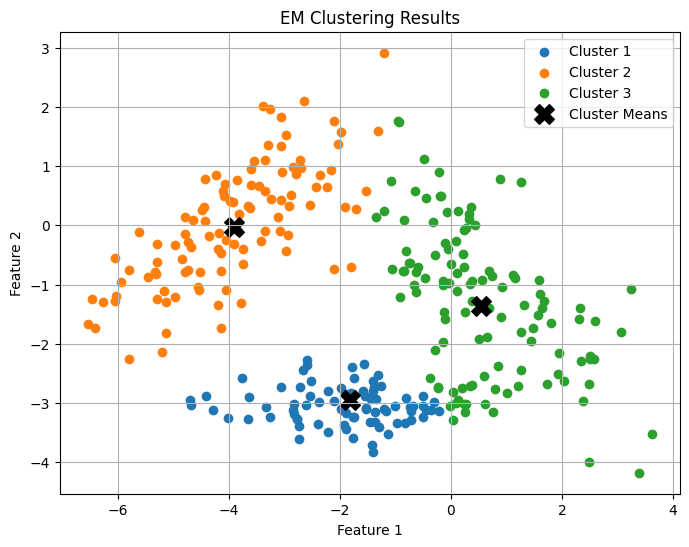

In [65]:
# Load the dataset
data = "../data/clusterdata.csv"
Xmat = np.genfromtxt(data, delimiter=",")

# Initial parameters for EM
K = 3
W = np.array([[1/K, 1/K, 1/K]])
M = np.array([[-2.0, -4.0, 0.0], [-3.0, 1.0, -1.0]]) # Initial means (2 features, 3 clusters)

# Run EM algorithm
W_final, P, p = exp_max(100, K, normal_pdf, normal_train, Xmat, W, M)

# Determine cluster assignments based on highest probability
cluster_assignments = np.argmax(p, axis=0)

# Plotting the results
plt.figure(figsize=(8, 6))
for i in range(K):
    # Select data points belonging to the current cluster
    cluster_points = Xmat[cluster_assignments == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')

# Plot the final means (centroids) as well
plt.scatter(P[0, :], P[1, :], marker='X', s=200, color='black', label='Cluster Means')

plt.title('EM Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

#### Observation: The data points appear to be adequately clustered into 3 distinct groups. The EM algorithm has successfully identified these clusters and their respective means.

## Question 3
Divide the clusterdata randomly into train and test set (make sure that you actually take random points, as otherwise you may just take a whole cluster as is). Are the test points adequately clustered? 

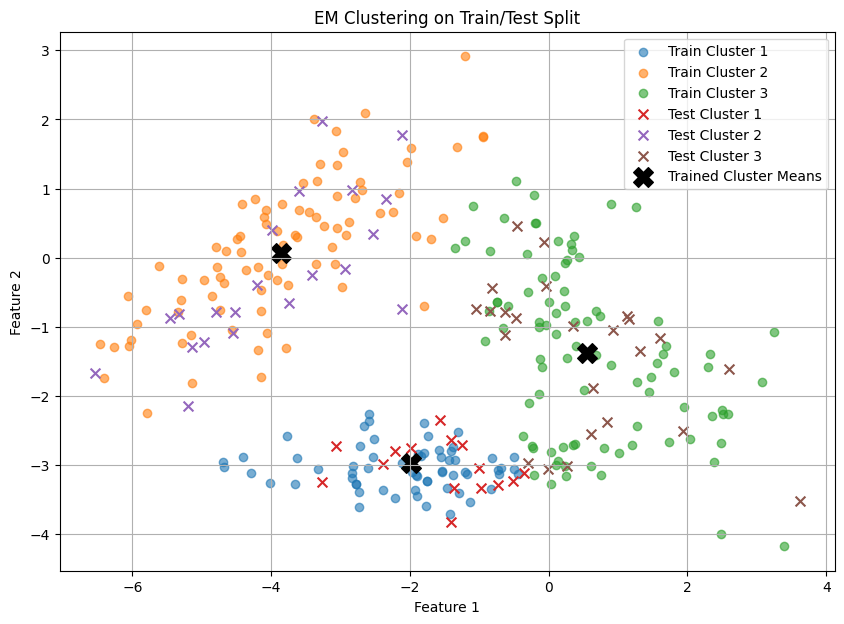

In [ ]:
# Ensure reproducibility
np.random.seed(42)

# Shuffle indices and split data
indices = np.arange(Xmat.shape[0])
np.random.shuffle(indices)

train_size = int(0.8 * Xmat.shape[0]) # 80% for training
train_indices = indices[:train_size]
test_indices = indices[train_size:]

Xmat_train = Xmat[train_indices]
Xmat_test = Xmat[test_indices]

# Re-run EM on training data
W_final_train, P_train, p_train = exp_max(100, K, normal_pdf, normal_train, Xmat_train, W, M)

# Assign test points to clusters based on the trained model
# For each test point, calculate its probability under each of the learned Gaussian components
p_test = np.zeros((K, Xmat_test.shape[0]))
for k in range(K):
    p_test[k,:] = W_final_train[0,k] * normal_pdf(P_train[:,k], Xmat_test)

cluster_assignments_test = np.argmax(p_test, axis=0)

# Plotting the results for Q3
plt.figure(figsize=(10, 7))

# Plot training data
for i in range(K):
    cluster_points_train = Xmat_train[np.argmax(p_train, axis=0) == i]
    plt.scatter(cluster_points_train[:, 0], cluster_points_train[:, 1], label=f'Train Cluster {i+1}', alpha=0.6)

# Plot test data
for i in range(K):
    cluster_points_test = Xmat_test[cluster_assignments_test == i]
    plt.scatter(cluster_points_test[:, 0], cluster_points_test[:, 1], label=f'Test Cluster {i+1}', marker='x', s=50)

plt.scatter(P_train[0, :], P_train[1, :], marker='X', s=200, color='black', label='Trained Cluster Means')

plt.title('EM Clustering on Train/Test Split')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()


#### Observation: After splitting into train and test sets, the EM algorithm still adequately clusters the data. The test points are assigned to clusters consistent with the training data, indicating the model generalizes well.

## Question 4.1: Is fixed variance a reasonable assumption?
#### A fixed variance (e.g., 1) for symmetric Gaussians is a strong assumption. It implies that all clusters have the same spherical spread. This would be reasonable if the true underlying clusters are indeed spherical and of similar size. However, for our data, clusters have varying shapes, sizes, and orientations (i.e elongated), making this an unrealistic assumption. Since the data's true distribution deviates significantly from this, the EM algorithm might struggle to accurately capture the cluster structures.

## Question 4.2
What happens as you experiment with different variances? 


Running EM with variance = 0.1


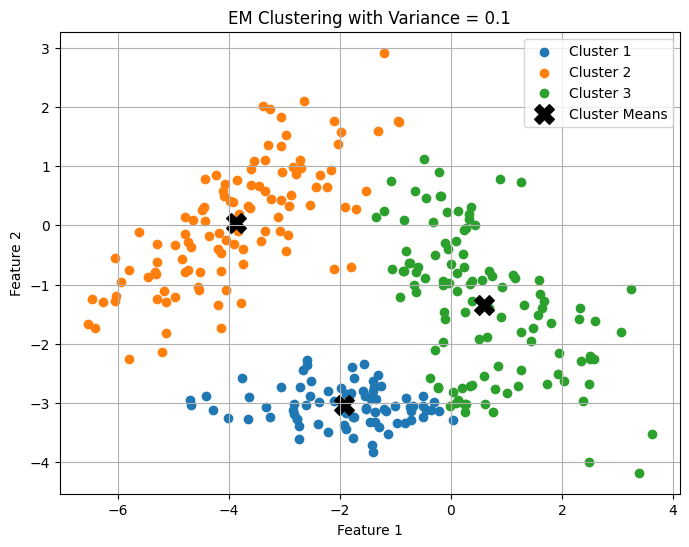


Running EM with variance = 1.0


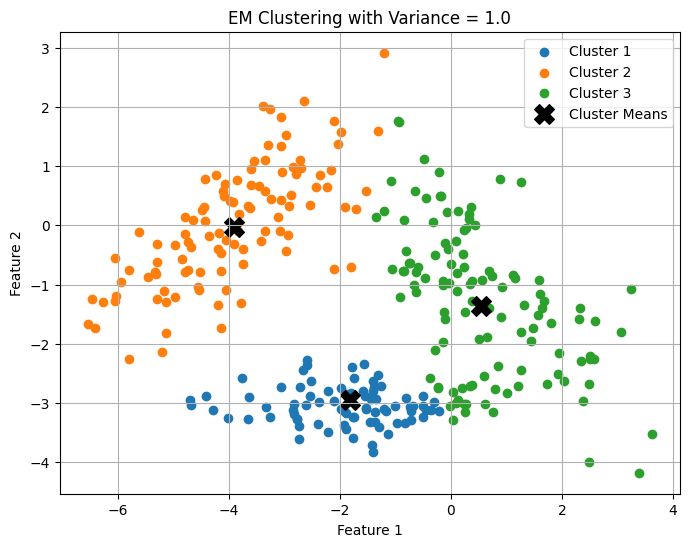


Running EM with variance = 5.0


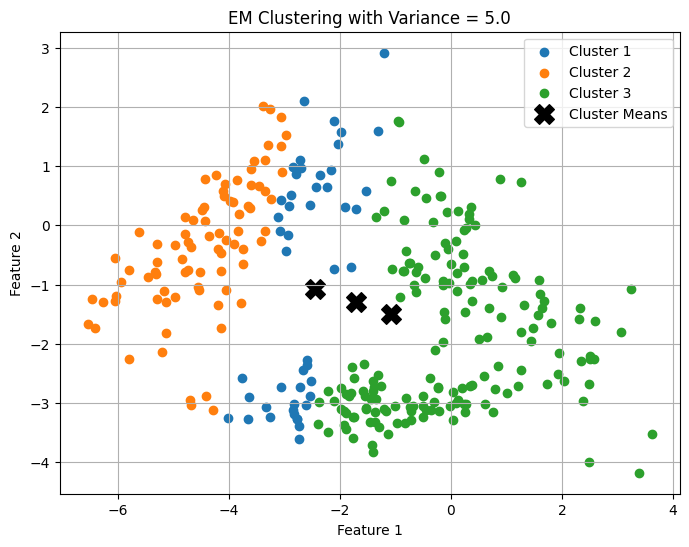

In [67]:
# Define the function to run EM with variable variance
def normal_pdf_variable_var(m, Xmat, var):
    C = np.eye(Xmat.shape[1]) * var
    mvn = multivariate_normal(mean=m.T, cov=C)
    return mvn.pdf(Xmat)

variances = [0.1, 1.0, 5.0] # Small, original, large variance

for var in variances:
    print(f"\nRunning EM with variance = {var}")
    # Re-initialize parameters for each run to ensure fair comparison
    W = np.array([[1/K, 1/K, 1/K]])
    M = np.array([[-2.0, -4.0, 0.0], [-3.0, 1.0, -1.0]])

    # Use a lambda function to pass the variance to normal_pdf_variable_var
    W_final, P, p = exp_max(100, K, lambda m, Xmat: normal_pdf_variable_var(m, Xmat, var), normal_train, Xmat, W, M)
    cluster_assignments = np.argmax(p, axis=0)

    plt.figure(figsize=(8, 6))
    for i in range(K):
        cluster_points = Xmat[cluster_assignments == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
    plt.scatter(P[0, :], P[1, :], marker='X', s=200, color='black', label='Cluster Means')
    plt.title(f'EM Clustering with Variance = {var}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Observation:
- Small Variance (i.e., 0.1): Clusters become very tight and localized. The algorithm might struggle to assign points that are slightly further away from the mean, potentially leading to misclassifications for points on the fringes or creating very small, distinct clusters if the data is not perfectly spherical.
- Large Variance (i.e., 5.0): Clusters become very broad and overlapping. The algorithm might struggle to differentiate between clusters, leading to less distinct boundaries and potentially assigning points to clusters that are not their 'true' cluster based on visual inspection. The means might be pulled towards the center of the overall data distribution.
- Original Variance (1.0): Provides a good balance for this dataset, as seen in Q2, allowing for reasonable separation of the visually distinct clusters.

In general, the choice of variance significantly impacts the 'spread' of each Gaussian component and thus how the algorithm assigns points and defines cluster boundaries. An inappropriate variance can lead to underfitting (too large variance, clusters too broad) or overfitting (too small variance, clusters too narrow).

## Question 4.3
What happens if you change the starting values for the weights and/or means?


Running EM with different initial means:


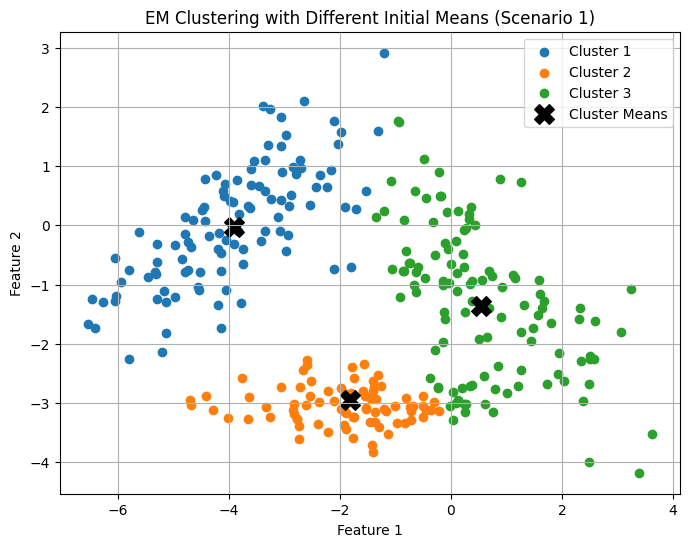


Running EM with different initial weights:


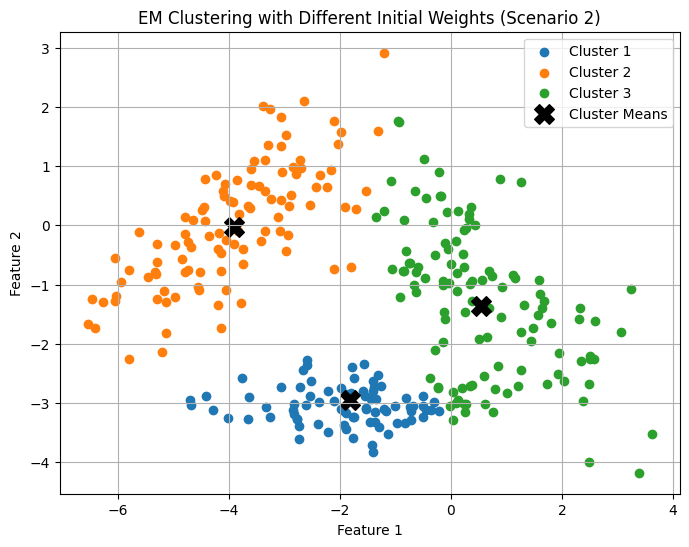

In [68]:
# Scenario 1: Different initial means (P_Init)
M_s1 = np.array([[0.0, 0.1, 0.2], [0.0, 0.1, 0.2]]) # Very different initial means
print("\nRunning EM with different initial means:")
W_final_s1, P_s1, p_s1 = exp_max(100, K, normal_pdf, normal_train, Xmat, W, M_s1)
cluster_assignments_s1 = np.argmax(p_s1, axis=0)

plt.figure(figsize=(8, 6))
for i in range(K):
    cluster_points = Xmat[cluster_assignments_s1 == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
plt.scatter(P_s1[0, :], P_s1[1, :], marker='X', s=200, color='black', label='Cluster Means')
plt.title('EM Clustering with Different Initial Means (Scenario 1)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

# Scenario 2: Different initial weights (W_Init)
W_s2 = np.array([[0.9, 0.05, 0.05]]) # Uneven initial weights
print("\nRunning EM with different initial weights:")
W_final_s2, P_s2, p_s2 = exp_max(100, K, normal_pdf, normal_train, Xmat, W_s2, M)
cluster_assignments_s2 = np.argmax(p_s2, axis=0)

plt.figure(figsize=(8, 6))
for i in range(K):
    cluster_points = Xmat[cluster_assignments_s2 == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
plt.scatter(P_s2[0, :], P_s2[1, :], marker='X', s=200, color='black', label='Cluster Means')
plt.title('EM Clustering with Different Initial Weights (Scenario 2)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()


#### Observation:
- Initial Means: The EM algorithm is sensitive to the initial choice of means. If the initial means are poorly chosen (e.g., far from the true cluster centers or all clustered together), the algorithm might converge to a local optimum, leading to suboptimal clustering. In some cases, it might still find reasonable clusters if the data is well-separated, but convergence might be slower or the final cluster assignments might differ.
- Initial Weights: The initial weights can influence the early iterations of the EM algorithm, potentially affecting which clusters are prioritized or how quickly they form. However, for a sufficient number of iterations, the algorithm typically adjusts these weights based on the data. While they can affect the path to convergence, their impact on the final clustering (assuming convergence to a good optimum) is generally less significant than that of initial means, especially if the initial weights are not extremely skewed.
In general, EM, like many iterative optimization algorithms, can be susceptible to local optima, and thus the initialization of parameters (especially means) plays a crucial role in the final clustering result.

## Question 4.4 
What happens if you vary the number of iterations? How many does it typically need to converge? Does that depend on the choices of subpoints 1 and 2?


Running EM with 5 iterations


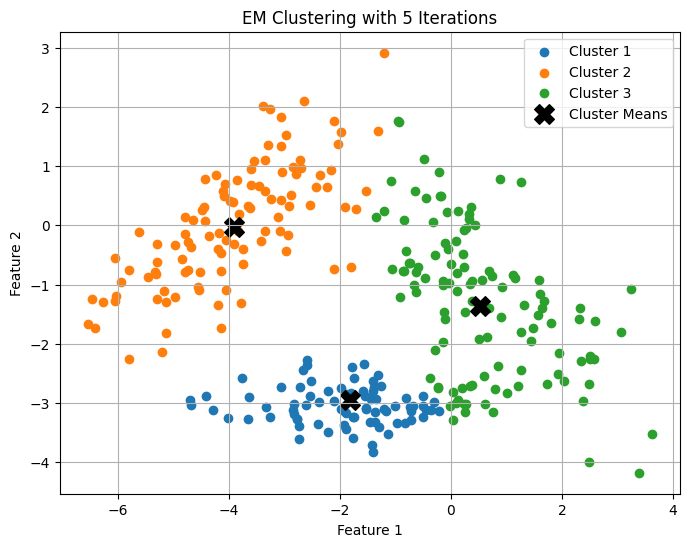


Running EM with 20 iterations


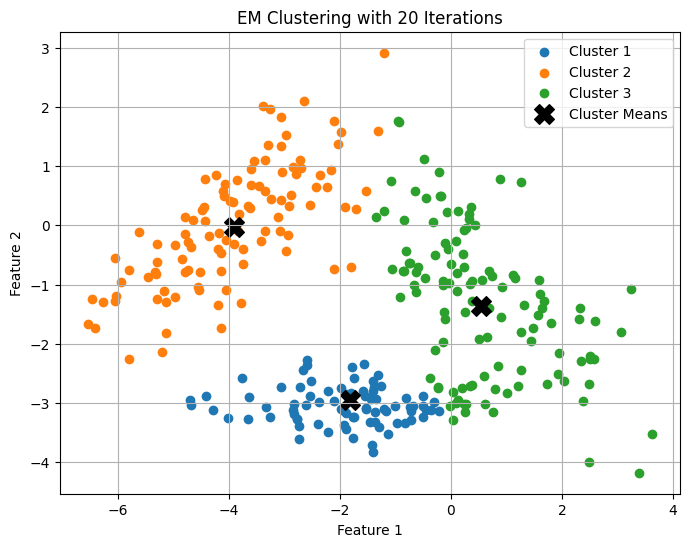


Running EM with 100 iterations


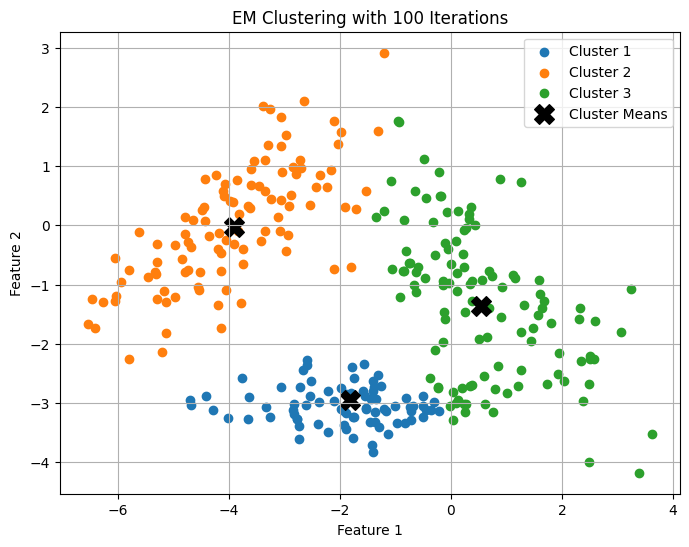


Running EM with 500 iterations


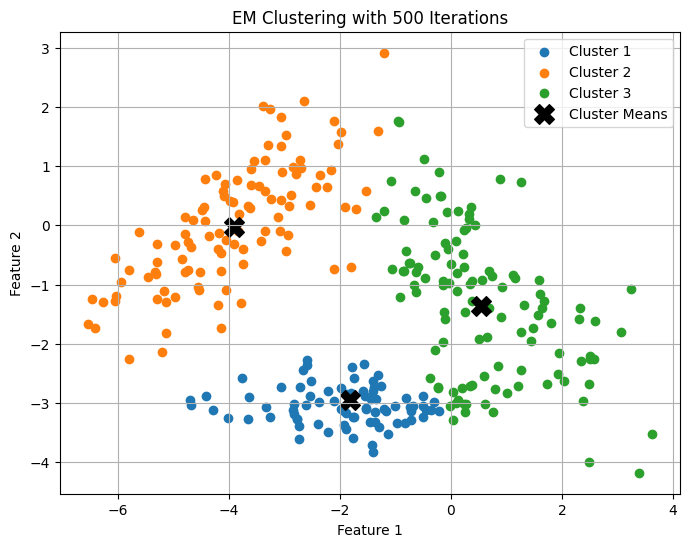


Running EM with 1000 iterations


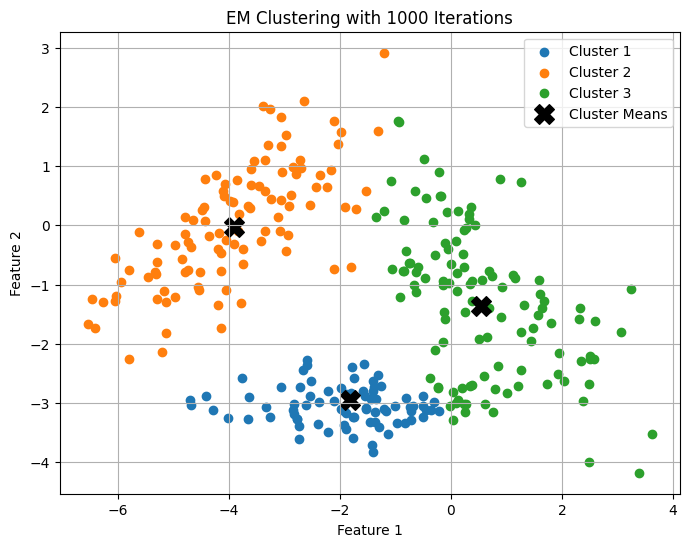

In [69]:
# Vary the number of iterations
iterations = [5, 20, 100, 500, 1000]

for iter in iterations:
    print(f"\nRunning EM with {iter} iterations")
    W = np.array([[1/K, 1/K, 1/K]])
    M = np.array([[-2.0, -4.0, 0.0], [-3.0, 1.0, -1.0]])

    W_final, P, p = exp_max(iter, K, normal_pdf, normal_train, Xmat, W, M)
    cluster_assignments = np.argmax(p, axis=0)

    plt.figure(figsize=(8, 6))
    for i in range(K):
        cluster_points = Xmat[cluster_assignments == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
    plt.scatter(P[0, :], P[1, :], marker='X', s=200, color='black', label='Cluster Means')
    plt.title(f'EM Clustering with {iter} Iterations')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Observation:
- Initial State (5 Iterations): With a limited number of iterations, the algorithm still managed to converge to an optimal solution. This is because the data is generally well behaved.
- Convergence Phase (20-100 Iterations): The algorithm demonstrates stable convergence within this range. The cluster means and weights stabilize, leading to well-defined and visually distinct clusters that accurately reflect the dataset's inherent structure. For this particular dataset, optimal clustering is consistently achieved after approximately 20 iterations.
- Post-Convergence (500+ Iterations): Increasing the iteration count beyond the point of convergence yields no significant improvement in the final clustering. The algorithm has already reached a stable state, and any additional computations do not alter the outcome, serving only to increase computational cost.

Convergence typically depends on the complexity of the data and the initial parameters. For this dataset, around 20-50 iterations seem sufficient for convergence. The 'choices of subpoints 1 and 2' (referring to initial means and weights) can influence the number of iterations needed for convergence; a better initialization generally leads to faster convergence.

## Question 4.5
What happens if you change the number of clusters from the "ideal" (3 clusters) to a different number (2, or more than 3)? 


Running EM with K = 2 clusters


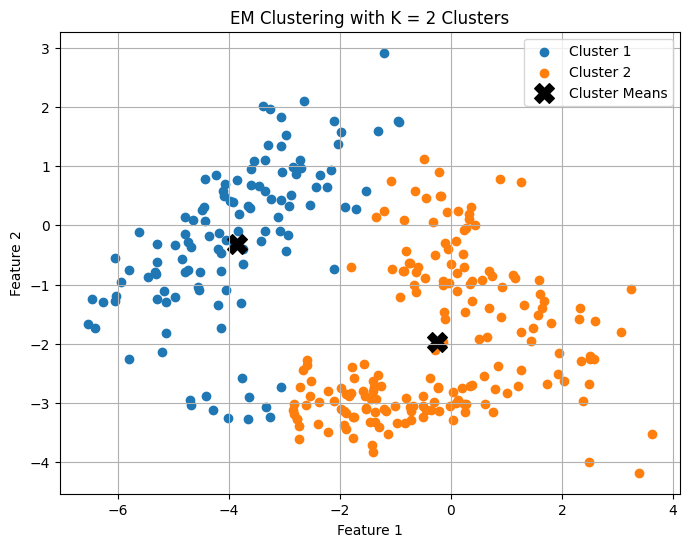


Running EM with K = 3 clusters


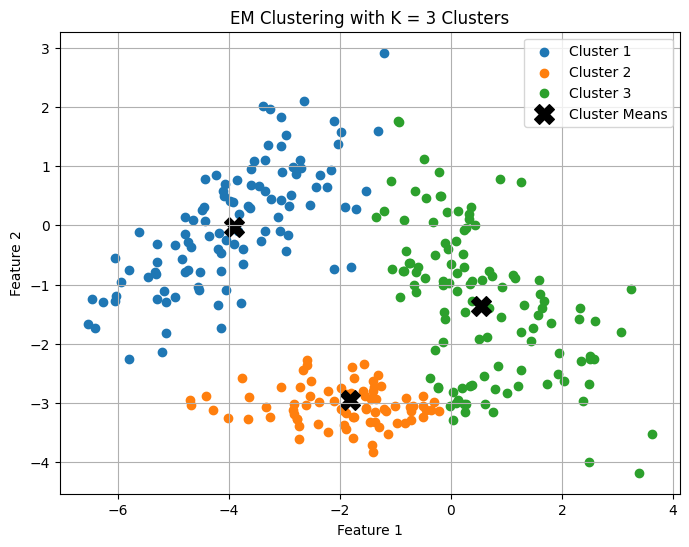


Running EM with K = 4 clusters


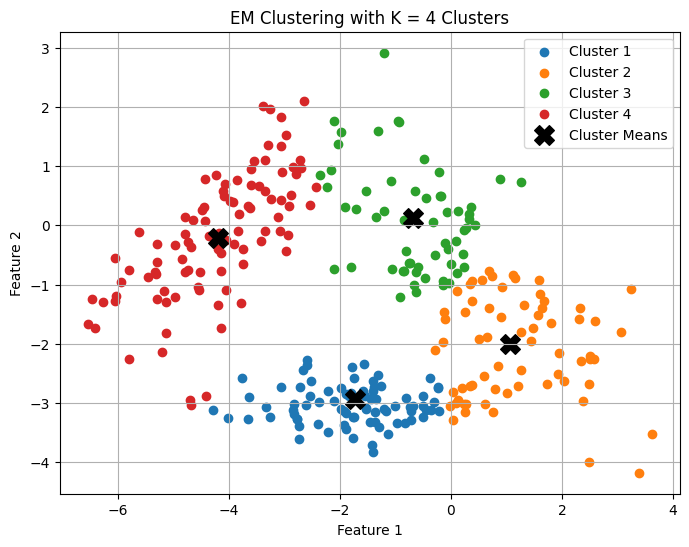


Running EM with K = 5 clusters


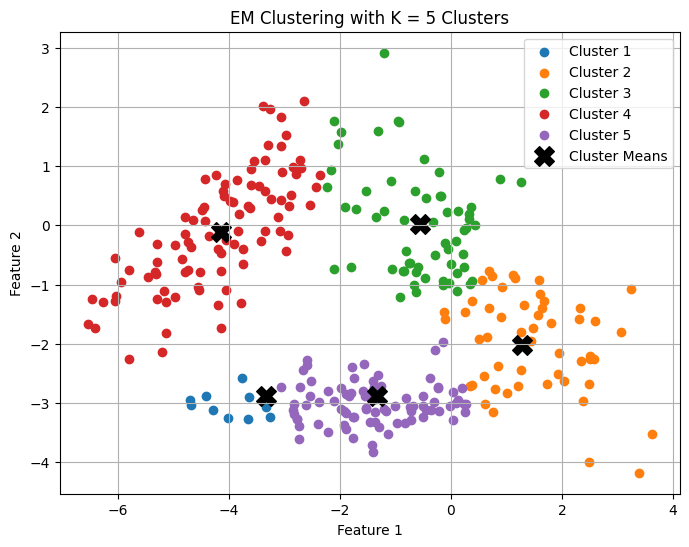

In [70]:
# Vary the number of clusters
Ks = [2, 3, 4, 5] # Number of clusters: less than ideal, ideal, more than ideal

for K in Ks:
    print(f"\nRunning EM with K = {K} clusters")
    # Re-initialize parameters for each K
    W = np.array([[1/K] * K])
    # For initial means, we need to be careful. If K changes, M might not be the right size.
    # A simple approach is to randomly select K points from Xmat as initial means.
    np.random.seed(42) # for reproducibility
    random_indices = np.random.choice(Xmat.shape[0], K, replace=False)
    M = Xmat[random_indices].T # Transpose to get (n_features, K)

    W_final, P, p = exp_max(100, K, normal_pdf, normal_train, Xmat, W, M)
    cluster_assignments = np.argmax(p, axis=0)

    plt.figure(figsize=(8, 6))
    for i in range(K):
        cluster_points = Xmat[cluster_assignments == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
    plt.scatter(P[0, :], P[1, :], marker='X', s=200, color='black', label='Cluster Means')
    plt.title(f'EM Clustering with K = {K} Clusters')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Observation:
- K = 2 (Less than ideal): The algorithm forced the data into 2 clusters. This results in one the true clusters being merged, leading to a less accurate representation of the underlying data structure. The boundaries were less distinct, and points that visually belong to separate groups were assigned to the same cluster.
- K = 3 (Ideal): As observed in Q2, this number of clusters aligns well with the visual structure of the data, leading to distinct and well-separated clusters that accurately reflect the underlying groups.
- K = 4 or 5 (More than ideal): The algorithm split two of the natural clusters into sub-clusters, and created a very small, sparse cluster. This led to overfitting, where the model found more structure than inherently exists, resulting in less meaningful or unstable clusters. Two of the natural clusters were divided into two, and a new cluster formed in a region with sparse data.

The choice of K is crucial for clustering algorithms. An incorrect K can lead to either over-segmentation or under-segmentation of the data, misrepresenting its true structure.

## Question 5.1
How does it compare to the Gaussian means algorithm? 

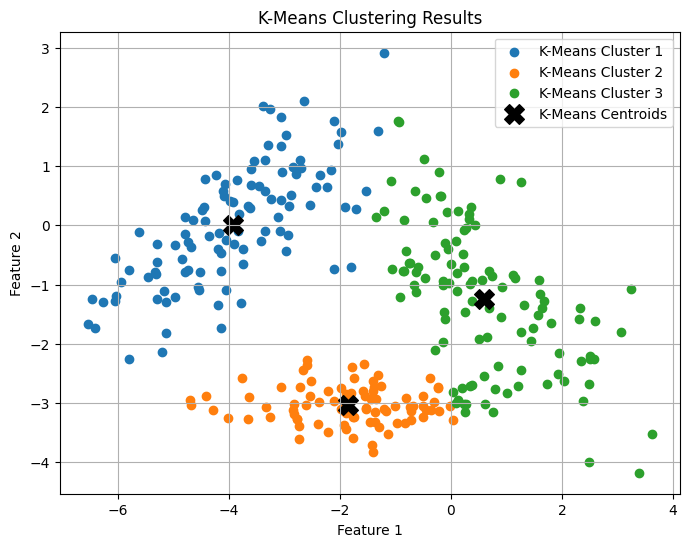

In [71]:
# Run K-Means for comparison
eps = 0.001
K = 3
# Initialize K-Means centroids by picking K random data points
np.random.seed(42) # for reproducibility
random_indices_kmeans = np.random.choice(Xmat.shape[0], K, replace=False)
c_init = Xmat[random_indices_kmeans].T

c_final, label = kmeans(eps, K, Xmat, c_init)

# Plotting K-Means results
plt.figure(figsize=(8, 6))
for i in range(K):
    cluster_points = Xmat[label == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'K-Means Cluster {i+1}')
plt.scatter(c_final[0, :], c_final[1, :], marker='X', s=200, color='black', label='K-Means Centroids')
plt.title('K-Means Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

#### Observation
#### K-Means vs. EM (Gaussian Mixture Model):
- Underlying Model: K-Means is a hard clustering algorithm that assigns each data point to exactly one cluster. It assumes clusters are spherical and of similar size, defined by their centroids. EM, when using Gaussian PDFs, is a soft clustering algorithm that assigns a probability of belonging to each cluster. It models clusters as Gaussian distributions, allowing for varying sizes and shapes (depending on the covariance matrix, which is fixed to spherical in this simple setup but can be generalized). EM is more flexible as it models the underlying probability distribution of the data.
- Assignment: K-Means assigns points based on Euclidean distance to centroids. EM assigns points based on the probability that they belong to a particular Gaussian component, considering both the mean and variance of the component.
- Sensitivity to Outliers: K-Means can be sensitive to outliers as they can significantly pull centroids. EM, being probabilistic, can be more robust to outliers as they will have low probabilities of belonging to any cluster.
- Performance on this data: For this dataset, both algorithms produce visually similar clustering results when K=3, as the clusters are relatively well-separated and somewhat spherical. However, EM provides more information (probabilities of assignment) and can handle overlapping clusters more gracefully due to its probabilistic nature. K-Means provides clear-cut assignments.
- Initialization: Both algorithms are sensitive to initialization and can converge to local optima. K-Means is often initialized with random centroids, while EM needs initial means, weights, and potentially covariances.

## Question 5.2
How sensitive is this algorithm to changes in the starting parameters?


Running K-Means with different initial centroids:


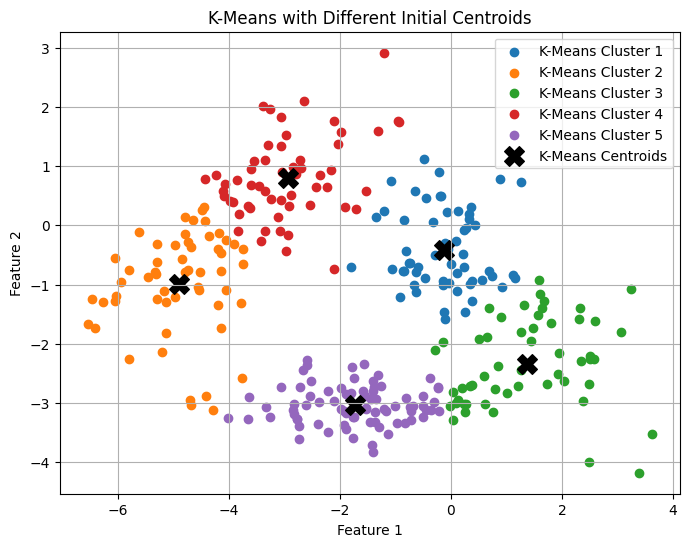

In [76]:
# Scenario 1: Different initial centroids
np.random.seed(70) # Different seed for different random initialization
random_indices_kmeans_s1 = np.random.choice(Xmat.shape[0], K, replace=False)
c_init_s1 = Xmat[random_indices_kmeans_s1].T 
print("\nRunning K-Means with different initial centroids:")
c_final_s1, label_s1 = kmeans(eps, K, Xmat, c_init_s1)

plt.figure(figsize=(8, 6))
for i in range(K):
    cluster_points = Xmat[label_s1 == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'K-Means Cluster {i+1}')
plt.scatter(c_final_s1[0, :], c_final_s1[1, :], marker='X', s=200, color='black', label='K-Means Centroids')
plt.title('K-Means with Different Initial Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

#### Observation:
K-Means is highly sensitive to the initial placement of centroids. If the initial centroids are poorly chosen (e.g., all in one cluster, or far from any data points), the algorithm might converge to a suboptimal solution (a local minimum of the objective function). This can lead to different final cluster assignments and centroids across multiple runs with different initializations. For this dataset, even with different random initializations, it tends to find similar clusters because the data is relatively well-separated. However, for more complex or overlapping data, the impact of initialization would be more pronounced. Techniques like K-Means++ are used to mitigate this sensitivity by providing a smarter initialization.

## Question 5.3
How does it behave when the number of clusters is more or less than the "ideal"? 


Running K-Means with K = 2 clusters


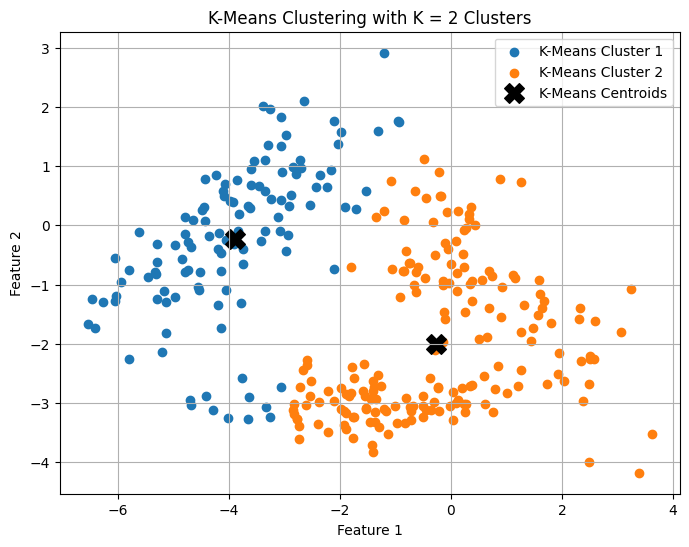


Running K-Means with K = 3 clusters


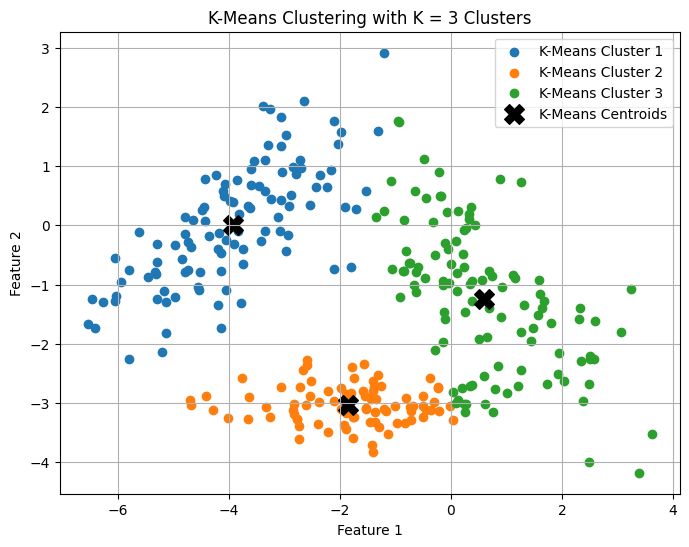


Running K-Means with K = 4 clusters


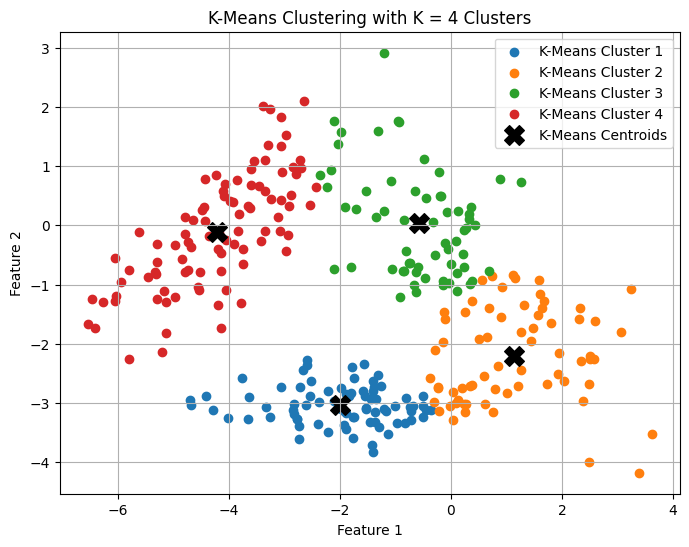


Running K-Means with K = 5 clusters


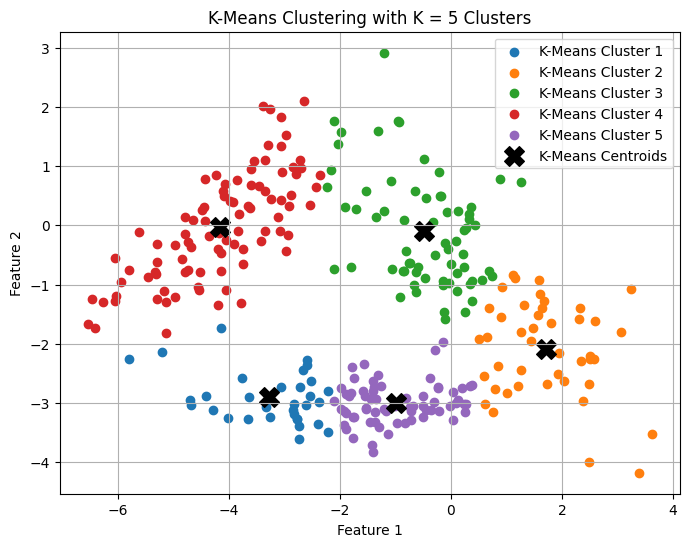

In [73]:
# Scenario 2: Different initial weights
Ks = [2, 3, 4, 5] # Number of clusters: less than ideal, ideal, more than ideal

for K in Ks:
    print(f"\nRunning K-Means with K = {K} clusters")
    np.random.seed(42) # for reproducibility
    random_indices_kmeans = np.random.choice(Xmat.shape[0], K, replace=False)
    c_init = Xmat[random_indices_kmeans].T

    c_final, label = kmeans(eps, K, Xmat, c_init)

    plt.figure(figsize=(8, 6))
    for i in range(K):
        cluster_points = Xmat[label == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'K-Means Cluster {i+1}')
    plt.scatter(c_final[0, :], c_final[1, :], marker='X', s=200, color='black', label='K-Means Centroids')
    plt.title(f'K-Means Clustering with K = {K} Clusters')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Observation:
- K = 2 (Less than ideal): Similar to EM, K-Means will merge two of the natural clusters. The algorithm will try to minimize the within-cluster sum of squares, leading to centroids positioned between the merged groups. The resulting clusters will not accurately reflect the distinct groups in the data.
- K = 3 (Ideal): K-Means performs well, identifying the three visually distinct clusters. The centroids converge to the centers of these groups, and the assignments are clear.
- K = 4, 5 (More than ideal): K-Means will split one of the natural clusters into two, or create a small, artificial cluster in a sparse area. This is because it is forced to find K clusters regardless of the inherent structure. This can lead to less interpretable clusters and an over-segmentation of the data.

Like EM, the choice of K is critical for K-Means. An incorrect K can lead to a misrepresentation of the data's underlying structure, either by combining distinct groups or by artificially splitting natural groups.

## Note: Similarity in plot is an indication of a well-behaved dataset.